In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco")
from lib.cgamma import _c_gamma_region1
from lib.cgamma import _c_gamma_region3
from lib.cgamma import _c_gamma_region4
from lib.cgamma import c_gamma_prob

In [3]:
from lib.plotting_tools import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [4]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco/data/network')

In [5]:
# Set choice of parameters.

dist = 10
z = -210
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)

# index 1 is main component
gamma_a = gamma_a[1]
gamma_b = gamma_b[1]
#gamma_a = 3.5
#gamma_b = 0.8
sigma = 3

xmax = 10 * dist

print(gamma_a, gamma_b)

3.609988410139153 0.8048957943430097


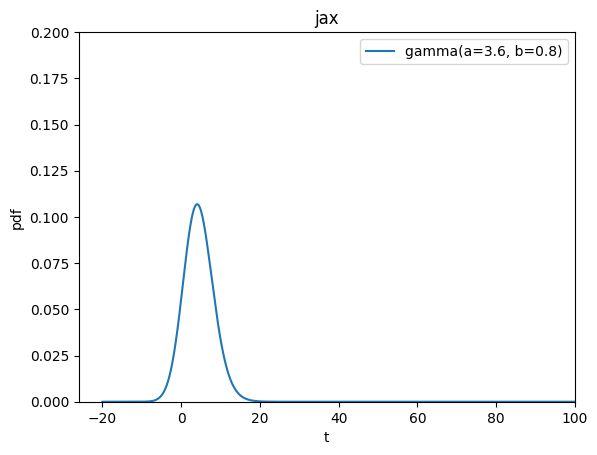

In [7]:
xvals = jnp.linspace(-20, xmax, 10000)
yvals = c_gamma_prob(xvals, gamma_a, gamma_b, sigma=sigma)


fig, ax = plt.subplots()
ax.plot(xvals, yvals, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')

ax.set_xlabel('t')
ax.set_ylabel('pdf')
ax.legend()
ax.set_title('jax')
ax.set_xlim(xmax=xmax)
ax.set_ylim([0.0, 0.2])
plt.show()

In [12]:
# can check error at transition boundary.

crit = gamma_b * sigma**2
delta = 10

yval_e = _c_gamma_region1(crit+delta, gamma_a, gamma_b, sigma=sigma)
yval_a = _c_gamma_region3(crit+delta, gamma_a, gamma_b, sigma=sigma)

print(100*(yval_a - yval_e)/yval_e)

yval_e = _c_gamma_region1(crit-delta, gamma_a, gamma_b, sigma=sigma)
yval_a = _c_gamma_region4(crit-delta, gamma_a, gamma_b, sigma=sigma)

print(100*(yval_a - yval_e)/yval_e)

0.002641806127976348
0.0015383822474221392


In [13]:
%timeit c_gamma_prob(xvals, gamma_a, gamma_b, sigma=sigma, delta=10)

16.1 ms ± 8.89 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%timeit c_gamma_prob(xvals, gamma_a, gamma_b, sigma=sigma, delta=5)

11.9 ms ± 35.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
